In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import time
from network import *
import simpy
import logging

In [2]:
logger= None

In [3]:
#Create and configure logger 
def initiate_logging ():
    logging.basicConfig(filename="newfile.log", 
                        format='%(asctime)s %(message)s', 
                        filemode='w') 

    #Creating an object 
    logger=logging.getLogger() 

    #Setting the threshold of logger to DEBUG 
    logger.setLevel(logging.DEBUG) 
    return logger

In [4]:
def wait(val):
    time.sleep(val * 0.01)

In [5]:
%matplotlib notebook
plt.ion()

In [6]:
env = simpy.Environment()

In [7]:
N = Network("stations.txt" , "railway.txt" , env)

In [8]:
#Creating the train class
class Train:
    id_ = 0
    def __init__ (self  , name , avg_speed , priority , route  , env , network):
        '''
        @parameters 
        name         : name of the train
        avg_speed    : average speed of the train
        priority     : priority of the train, later will be used in the algorithm
        route        : a python list of touple that gives the stations on the route along with the expected time 
                       of departure
        env          : Simpy environment where simulation is done
        network      : network on which the train is running 
        
        TODO
        ____________________________________
        
        Notes :
        1. Time is just an integer for current. It can change in the future.
        2. Simmulation starts at time 0. So the time in the route should always be greater than 0
        3. We assume that the arrival and departure time of the trains are the same for each station in the route.
           However in the log it is possible to have the arrival and departure time different.
        
        '''
        
        #initialise the variables
        self.__class__.id_ += 1
        self.id = self.__class__.id_
        self.name = name
        self.speed = avg_speed
        self.priority = priority
        self.route = route
        self.env = env              
        self.network = network

        #for the current status of the train
        self.running = False                        #True if the train is running                        
        self.station_or_not = False                 #True if standing on station
        self.current = '_'                          #Current station name or the track (tuple)
        self.current_index = -1                     #upto which point the route is travelled
        self.current_track = -1                     #current track number on the particular station or track  
        self.done = False                           #indicate wether the journey is complete or not
        
        #resource that the train is acquiring currently
        self.resource = None   
        self.request = None
        
        #for storing the log
        self.log = [(d , -1 , -1) for d,t in route]          #(station_name , arrival , departure)
        
    def compute_time (self , distance):
        '''
        returns the time needed to travel the distance  
        @paramters :
        distance : to be travelled
        
        '''
        return distance/self.speed
    
            
    def move_train (self , env):
        '''
        ONLY FOR SIMULATION
        This function runs the train
        This function is only used for simulation purpose
        It will start the whole train and then finishes the journey
        '''
        #Create the relevant processes
        initiate_train_proc = env.process (self.initiate_train(self.env))
        yield initiate_train_proc
        yield env.timeout(2)
        
        while self.done == False:
            move_train_one_step_proc = env.process (self.move_train_one_step(env))
            yield move_train_one_step_proc
            yield env.timeout(2)
        
        yield env.timeout(1)
        finish_journey_process = env.process (self.finish_journey(self.env))
        yield finish_journey_process
    
    def initiate_train (self , env):
        '''
        This function puts the train on the track
        This function is initialised as the process in the __init__ function
        @parameters
        env : simpy environment
        '''
        logger.info("Train {} initiating at time {}".format(self.name , env.now) )
        start_station , start_time = route[0]
        
        #wait till the right time comes to be on train
        wait = max (0 , start_time - env.now)
        yield env.timeout(wait)
        
        
        #try to acquire the resource related to the station
        #It may be possible that the station is all full and the train cannot be put there.
        #In that case, we have to wait to put train on the station
        resource = self.network.get_station_resource (start_station)
        request = resource.request()
        yield request                            #wait for the station to be free
        self.resource = resource                 
        self.request = request
        
        #acuire the station
        self.current_track = self.network.lock_station (start_station , self.name)
        
        #update the current status
        self.current_index = 0 
        self.current = start_station
        self.station_or_not = True
        self.running = True
        
        #update the log
        self.log[self.current_index] = (start_station , env.now , -1)
        
        logger.info("Train {} inited at time {}".format(self.name , env.now) )
        

            
        
    def wait_train (self, env):
        '''
        This function waits for one unit time
        '''
        yield env.timeout(1)
        
    def move_train_one_step (self, env):
        '''
        Move the train
        This function does not move the train before the tentative time table
        If already reached destination then returns -1
        '''
        #if the train is not running return -1
        if (self.running == False):
            return -1
        
        
        #If the train is on the station and ready to depart
        if (self.station_or_not):
             
            '''
            Since the train is on the station
                  - If already reached the final station then return -1
                  - if not, then leave the station track and try to acuire the next track in between the stations
                  
            '''
            
            #if the train has completed the journey
            if (self.done):
                return -1

            
            current_station , depart_time = self.route[self.current_index]
            next_station , dest_time = self.route[self.current_index + 1]
            current_time = env.now
            track = self.network.G[current_station][next_station]['details']
            logger.info("Train {} time : {} Try to depart to track {}-{}".format(self.name , env.now ,
                                                                              current_station , next_station) )
            #wait If reached the station before the depart time
            wait = max(0 , depart_time - current_time)
            yield env.timeout (wait)
            
            #now try to acquire the track in between the station
            resource = self.network.get_track_resource (current_station , next_station)
            request = resource.request()
            yield request
            
            prev_track = self.current_track
            self.current_track = self.network.lock_track(current_station , next_station , self.name)
            
            #release the current resource
            self.resource.release(self.request)
            self.network.free_station(current_station , prev_track)
            self.resource =  resource
            self.request = request
            
            logger.info("Train {} time : {} On track {}-{}".format(self.name , env.now ,
                                                                              current_station , next_station) )
            #update the log ; depart time
            self.log[self.current_index] = (self.log[self.current_index][0] , self.log[self.current_index][1] ,  env.now) 
        
            #travel down the track
            len_of_track = track.length_of_tracks[self.current_track]
            time_to_travel = self.compute_time(len_of_track)
            yield env.timeout (time_to_travel)
            
            logger.info("Train {} time : {} Travelled on track {}-{}".format(self.name , env.now ,
                                                                              current_station , next_station) )
            #update the current_status 
            self.current = (current_station , next_station) 
            self.station_or_not = False                       #on the track
            
        else:
            '''
            Train has travelled down the track and waiting to arrive to the station
            '''
            #we are moving from station_x to station_y 
            station_x , station_y  = self.current
            logger.info("Train {} time : {} Try to arrive at station {}".format(self.name , env.now ,
                                                                              station_y ) )
            #try to acquire the track on the next station
            resource = self.network.get_station_resource(station_y)
            request = resource.request()
            yield request
            
            prev_track = self.current_track
            self.current_track = self.network.lock_station (station_y , self.name)
            
            #release the current resource
            self.resource.release(self.request)
            self.network.free_track (station_x , station_y , prev_track)
            self.resource = resource
            self.request = request
            
            logger.info("Train {} time : {} Arrived at station {}".format(self.name , env.now ,
                                                                              station_y ) )
            self.current = station_y
            self.station_or_not = True
            self.current_index += 1
            
            #arrival time
            self.log[self.current_index] = (self.log[self.current_index][0] , env.now ,  -1 ) 
            
            #if completed the journey
            if (self.current_index == len(route) - 1):
                logger.info("Train {} time : {} Completed journey.".format(self.name , env.now ) )
                self.done = True
                self.running = False
                
        return 0
                
    def finish_journey (self , env):
        '''
        This function is used when the train finishes it's journey.
        '''
        if (self.done == True):
            #release all the resource
            
            self.resource.release(self.request)
            self.network.free_station(route[-1][0] , self.current_track)
            #logging 
            logger.info("Train :{} Time : {} Completed Journey : Released all the resources ".format(self.name , env.now))
            yield env.timeout(2)
        
    def print_details (self):
        '''
        Prints all the information of the train
        '''
        print(50 * '*')
        print("Train ID : {}".format(self.id_))
        print("Name :{}".format(self.name))
        print("Priority : {}".format(self.priority))
        print("Average speed : ".format(self.speed))
        if (self.running):
            print("Train is running")
            if (self.station_or_not):
                print("Currently at station {}".format(self.current))
            else:
                print("Currently on track {}-{}".format(self.current[0] , self.current[1]))
        else:
            print('Train not travelling')
        
        print("Route of the train")
        for d,t in self.route:
            print("            {} : {} ".format(d , t))
        print(50 * '*')
        
        if (self.done):
            print("Train has completed the journey")
            print ("______Printing log________")
            for d, t_a , t_d in self.log:
                print("            {} : {} {} ".format(d , t_a , t_d))
            

In [9]:
#utility function
def update_graph (env , interval):
    '''
    This function will simulate the whole process on a GUI
    This function is going to be used as the process
    @parameters
    env : simpy environment
    total_time : total time for the simulation
    '''
    fig = plt.figure(figsize = (8 , 8))
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    
    while True:
        #Draw graph
        
        N.draw_railway_network(ax  = ax , suppress_station_info= False , 
                               suppress_track_info= False , suppress_edge_label=False)

        #yield interval time
        yield env.timeout(interval)
        time.sleep(0.1)
        
        #log info
        logger.info("Time : {} Updating Graph".format(env.now))
        plt.title("Time {}".format(env.now))
        
        #Paint the canvas
        fig.canvas.draw()

In [10]:
#initialize the variable for the instance
name = 'Shatabdi'
speed=1
priority = 3
route = [
        ('Alpha' , 10),
        ('Beta' ,  15),
        ('Gamma' , 27),
        ('Zeta' , 32),
        ]

In [11]:
train = Train (name , speed , priority , route , env , N)

In [12]:
train.print_details()

**************************************************
Train ID : 1
Name :Shatabdi
Priority : 3
Average speed : 
Train not travelling
Route of the train
            Alpha : 10 
            Beta : 15 
            Gamma : 27 
            Zeta : 32 
**************************************************


In [13]:
logger = initiate_logging()

<IPython.core.display.Javascript object>


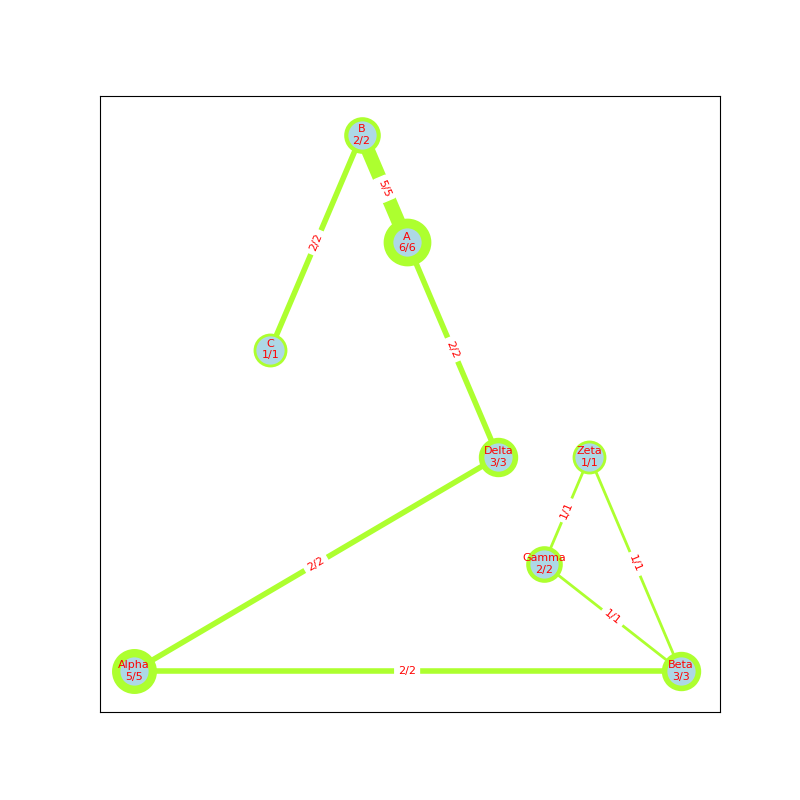

In [14]:
proc = env.process(train.move_train(env))
sim_proc = env.process(update_graph(env , 1))
env.run(until = 60)

In [15]:
train.print_details()

**************************************************
Train ID : 1
Name :Shatabdi
Priority : 3
Average speed : 
Train not travelling
Route of the train
            Alpha : 10 
            Beta : 15 
            Gamma : 27 
            Zeta : 32 
**************************************************
Train has completed the journey
______Printing log________
            Alpha : 10 12 
            Beta : 18.0 20.0 
            Gamma : 26.0 28.0 
            Zeta : 35.0 -1 


In [16]:
# TODO
'''
1. Create a simple train class with all the parameters
2. Implement the resource facility with the track and the station
3. Run the single train on the track (without getting worried wether the resource is free or not)
4. Simulate whole thing on graph (single train only)
5. Run multiple instances of the train without worrying about the deadlock
6. Try to simulate as you want to do in the project i.e. take action from the user.

7. Try to create deadlock with the trains
8. Create the graph for resource usage.
9. Use the standard deadlock detection algorithm for the detection of the algorithm 
   Implement the Bank's algorithm for deadlock detection.
'''

"\n1. Create a simple train class with all the parameters\n2. Implement the resource facility with the track and the station\n3. Run the single train on the track (without getting worried wether the resource is free or not)\n4. Simulate whole thing on graph (single train only)\n5. Run multiple instances of the train without worrying about the deadlock\n6. Try to simulate as you want to do in the project i.e. take action from the user.\n\n7. Try to create deadlock with the trains\n8. Create the graph for resource usage.\n9. Use the standard deadlock detection algorithm for the detection of the algorithm \n   Implement the Bank's algorithm for deadlock detection.\n"

In [17]:
N.print_details()

**************************************************
Station 1
Station name : Alpha
Number of tracks : 5
Number of free tracks : 5
Track status
Track 0 : free
Track 1 : free
Track 2 : free
Track 3 : free
Track 4 : free
**************************************************
**************************************************
Station 2
Station name : Beta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**************************************************
Station 3
Station name : Gamma
Number of tracks : 2
Number of free tracks : 2
Track status
Track 0 : free
Track 1 : free
**************************************************
**************************************************
Station 4
Station name : Delta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**********************************